# Problem 1: Split the data

Prepare the data by encoding the non-numeric variables and applying a train-test split:

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('data/life_expectancy.csv')

label_encoder = LabelEncoder()
data['Country'] = label_encoder.fit_transform(data['Country'])

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Problem 2: Single variable linear regression model

### Find a candidate variable

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Pearson correlation coefficient:

In [18]:
target_variable = 'Life Expectancy at Birth, both sexes (years)'

correlations = data_train.corr(method='pearson')[target_variable].sort_values(ascending=False)

candidate_variable = correlations.index[1]
print(f'Candidate variable: "{candidate_variable}"')

Candidate variable: "Human Development Index (value)"


### Constructing the model

Construct a linear regression model using the variable with the strongest relationship with the target variable:

In [19]:
from sklearn.linear_model import LinearRegression

X_train = data_train[[candidate_variable]]
y_train = data_train[target_variable]

model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

Computing the metrics of the model:

In [20]:
r_squared = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.8433493090941087
Coefficients: [51.42339338]
Intercept: 34.60462419807184


Plot the linear regression model:

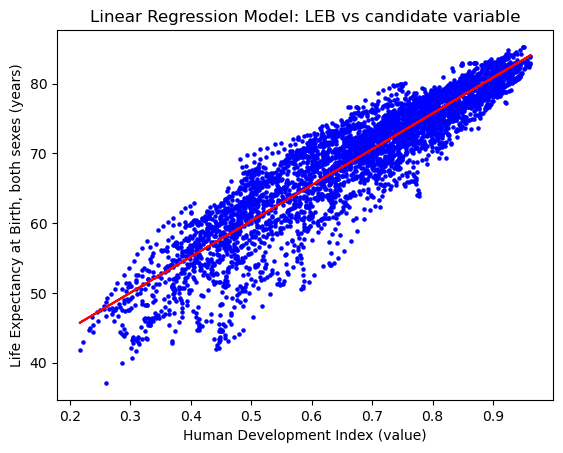

In [21]:
import matplotlib.pyplot as plt

plt.scatter(X_train, y_train, color='blue', s=5)
plt.plot(X_train, model.predict(X_train), color='red')
plt.title('Linear Regression Model: LEB vs candidate variable')
plt.xlabel(candidate_variable)
plt.ylabel(target_variable)

plt.savefig("scatter_plot_single_linear_model.png")

### Predict the test set

Predict the target variable using the test data and computing the **mean squared error** and **correlation coefficient**:

In [22]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

X_test = data_test[[candidate_variable]]
y_test = data_test[target_variable]
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
correlation, _ = pearsonr(y_pred, y_test)

print(f'Mean squared error: {mse}')
print(f'Correlation: {correlation}')


Mean squared error: 12.519251362188522
Correlation: 0.920387001630666


# Problem 3: Non-linear relationship

### Find a second candidate

Identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` using the Spearman correlation coefficient:

In [23]:
data_train = data_train.drop(columns=[candidate_variable])

correlations = data_train.corr(method='spearman')
correlations[target_variable].abs().sort_values(ascending=False)

Life Expectancy at Birth, both sexes (years)                                       1.000000
Gross National Income Per Capita (2017 PPP$)                                       0.864828
Median Age, as of 1 July (years)                                                   0.863765
Crude Birth Rate (births per 1,000 population)                                     0.848640
Expected Years of Schooling, female (years)                                        0.834567
Coefficient of human inequality                                                    0.828904
Expected Years of Schooling (years)                                                0.819759
Total Fertility Rate (live births per woman)                                       0.816936
Adolescent Birth Rate (births per 1,000 women ages 15-19)                          0.811920
Expected Years of Schooling, male (years)                                          0.806563
Material footprint per capita (tonnes)                                          

Plotting the relationship:

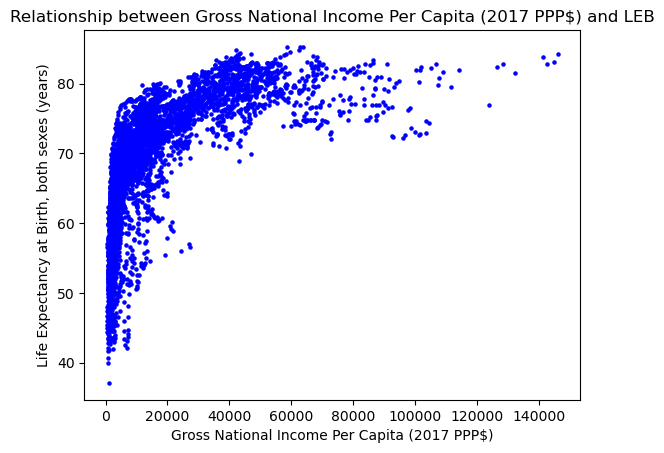

In [24]:
second_candidate_variables = 'Gross National Income Per Capita (2017 PPP$)'

plt.scatter(data_train[second_candidate_variables], data_train[target_variable], color='blue', s=5)
plt.title('Relationship between Gross National Income Per Capita (2017 PPP$) and LEB')
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)

plt.savefig("scatter_plot_nonlinear_mono_model.png")

The relationship appears to be a logarithmic relationship. 

### Construct the model on the transformed scale

Applying the logarithmic transformation to the candidate variable:

In [25]:
import numpy as np

X_train = data_train[[second_candidate_variables]]
y_train = data_train[target_variable]

log_X_train = np.log(X_train)

model = LinearRegression()
model.fit(log_X_train, y_train)

LinearRegression()

Computing the metrics of the model:

In [26]:
r_squared = model.score(log_X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.6939267719160521
Coefficients: [6.46720934]
Intercept: 9.942320920335249


Plotting the linear regression model:

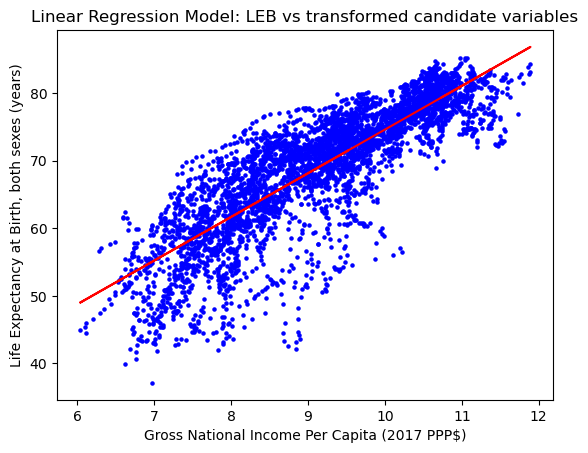

In [27]:
plt.scatter(log_X_train, y_train, color='blue', s=5)
plt.plot(log_X_train, model.predict(log_X_train), color='red')
plt.title('Linear Regression Model: LEB vs transformed candidate variables')
plt.xlabel(second_candidate_variables)
plt.ylabel(target_variable)

plt.savefig("scatter_plot_nonlinear_mono_transformed_model.png")

### Comparing the transformation
Computing the correlation coefficient before and after the transformation

In [28]:
original_correlation, _ = pearsonr(X_train.values.flatten(), y_train)
transformed_correlation, _ = pearsonr(log_X_train.values.flatten(), y_train)

print(f'Original correlation:    {original_correlation}')
print(f'Transformed correlation: {transformed_correlation}')

Original correlation:    0.6514708331957302
Transformed correlation: 0.833022671909986


# Problem 4: Multiple linear regression model

### Systematically research the candidates

Apply a systematic search to identify the variables with the strongest relationship with the target variable `Life Expectancy at Birth, both sexes (years)` without using the most correlated variable. 

A Recursive Feature Elimination strategy has been used.

In [29]:
from sklearn.feature_selection import SelectKBest, f_regression

data_train = data_train.dropna()
data_test = data_test.dropna()

X_train = data_train.drop(columns=[target_variable])
y_train = data_train[target_variable]

selector = SelectKBest(f_regression, k=5)
selector.fit(X_train, y_train)

candidates = X_train.columns[selector.get_support()]

candidates_list = "\n".join(candidates)
print(f'Selected features: \n{candidates_list}')

Selected features: 
Coefficient of human inequality
Median Age, as of 1 July (years)
Rate of Natural Change (per 1,000 population)
Crude Birth Rate (births per 1,000 population)
Total Fertility Rate (live births per woman)


### Alternative candidates (Janna version)

We believe the spearman coefficient is an effective way to select variables as it gives an indicator of how strong the relationship between the variable and LEB is. 

We consider the top 7 variables with spearman coefficients of the highest magnitude. These are:

- Gross National Income Per Capita (2017 PPP$)
- Median Age, as of 1 July (years)
- Crude Birth Rate (births per 1,000 population)
- Expected Years of Schooling, female (years)
- Coefficient of human inequality
- Expected Years of Schooling (years)
- Total Fertility Rate (live births per woman)

However, `Expected Years of Schooling (years)` is able to capture the information from `Expected Years of Schooling. female (years)`. 

This leaves us with 6 remaining variables to consider further and test.

In [30]:
# TODO: find out why RFE doesn't work
# candidates = [
# 	'Gross National Income Per Capita (2017 PPP$)',
# 	'Median Age, as of 1 July (years)',
# 	'Crude Birth Rate (births per 1,000 population)',
# 	'Expected Years of Schooling, female (years)',
# 	'Coefficient of human inequality',
# 	'Expected Years of Schooling (years)',
# 	'Total Fertility Rate (live births per woman)',
# ]

### Construct the model

Construct a linear regression model using the found candidates with the target variable:

In [31]:
X_train = data_train[candidates]

model = LinearRegression()
model.fit(X_train, y_train)

r_squared = model.score(X_train, y_train)
coefficients = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficients: {coefficients}')
print(f'Intercept: {intercept}')

R-squared: 0.9703153322838306
Coefficients: [-0.09895655  0.70923533  1.70270563 -2.13815957  2.98240358]
Intercept: 67.97955121326358


### Predict the test set

Predict the target variable using the test data and computing the **mean squared error** and **correlation coefficient**:

In [32]:
X_test = data_test[candidates]
y_test = data_test[target_variable]
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
correlation, _ = pearsonr(y_pred, y_test)

print(f'Mean squared error: {mse}')
print(f'Correlation: {correlation}')

Mean squared error: 2.2279402053130903
Correlation: 0.9854073119079798


Mean squared error: 7.216409900118977

Correlation: 0.9519879090178236
